# A Simple Stock Predictor

## Objective 

*Given The SP500 data from Yahoo finance. Can we predict if the next day will go up or down?*

## Methodology

1. Data Preperation
2. Simple Feature Creation
3. Using LightGBM + Optuna to making a model
4. Use the model to predict unseen data 
5. Evaluation



In [1]:
#Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time 

# library for sampling
from scipy.stats import uniform

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import yfinance as yf

# sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split


C:\Users\harri\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Imports data
start_sp=datetime.datetime(1980, 1, 1) 
end_sp=datetime.datetime(2020, 5, 31)

yf.pdr_override() 
data=pdr.get_data_yahoo('^GSPC', 
                        start_sp,
                        end_sp)
data.shape

[*********************100%***********************]  1 of 1 completed


(10191, 6)

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1979-12-31,107.839996,108.529999,107.260002,107.940002,107.940002,31530000
1980-01-02,107.940002,108.430000,105.290001,105.760002,105.760002,40610000
1980-01-03,105.760002,106.080002,103.260002,105.220001,105.220001,50480000
1980-01-04,105.220001,107.080002,105.089996,106.519997,106.519997,39130000
1980-01-07,106.519997,107.800003,105.800003,106.809998,106.809998,44500000


## Create Features

In [4]:
def prepare_data(data):  
    # Compute the logarithmic returns using the Closing price 
    data['Log_Ret_1d']=np.log(data['Close'] / data['Close'].shift(1))

    # Compute logarithmic returns using the pandas rolling mean function
    n_lag = [1,2,3,4,7,8,12,14,16,20,24,28,32,36,40,44,48,52,56,60,64,68,72,76,80]

    for i in n_lag:  
        # Compute logarithmic returns using the pandas rolling mean function
        data[f'Log_Ret_{str(i)}w']=pd.Series(data['Log_Ret_1d']).rolling(window=i*5).sum()

    for i in n_lag:
        # Compute Volatility using the pandas rolling standard deviation function
        data[f'Vol_{str(i)}w']=pd.Series(data['Log_Ret_1d']).rolling(window=i*5).std()*np.sqrt(i*5)

    for i in n_lag:
        # Compute Volumes using the pandas rolling mean function
        data[f'Volume_{str(i)}w']=pd.Series(data['Volume']).rolling(window=i*5).mean()

    return_features = ['Open', 'Close']
    
    def create_lag(df_code, n_lag=n_lag, shift_size=1):
        
        for col in return_features:
            for window in n_lag:
                rolled = df_code[col].shift(shift_size).rolling(window=window)
                lag_mean = rolled.mean()
                lag_max = rolled.max()
                lag_min = rolled.min()
                df_code['%s_lag_%s_mean' % (col, window)] = lag_mean
                df_code['%s_lag_%s_max' % (col, window)] = lag_max
                df_code['%s_lag_%s_min' % (col, window)] = lag_min
                
        return df_code

    data = create_lag(data)


    data['Return_Label']=pd.Series(data['Log_Ret_1d']).shift(-1).rolling(window=1).sum() # 1 for day trading, 7 is a better number
    data['Label']=np.where(data['Return_Label'] > 0, 1, 0)

    # Drop NA´s
    data=data.dropna("index")
    data=data.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', "Return_Label"], axis=1)
    
    return(data)

In [5]:
sp500 = prepare_data(data)
sp500.tail(5)

,Log_Ret_1d,Log_Ret_1w,Log_Ret_2w,Log_Ret_3w,Log_Ret_4w,Log_Ret_7w,Log_Ret_8w,Log_Ret_12w,Log_Ret_14w,Log_Ret_16w,...,Close_lag_72_mean,Close_lag_72_max,Close_lag_72_min,Close_lag_76_mean,Close_lag_76_max,Close_lag_76_min,Close_lag_80_mean,Close_lag_80_max,Close_lag_80_min,Label
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-21,-0.007804,0.033104,0.023097,0.012312,0.052467,0.176879,0.174833,-0.055375,-0.129971,-0.105396,...,2858.088874,3386.149902,2237.399902,2881.702354,3386.149902,2237.399902,2900.852484,3386.149902,2237.399902,1
2020-05-22,0.002351,0.031536,0.008717,0.043123,0.040995,0.156658,0.116640,-0.007856,-0.134062,-0.102178,...,2852.822208,3386.149902,2237.399902,2877.749592,3386.149902,2237.399902,2896.755859,3386.149902,2237.399902,1
2020-05-26,0.012214,0.012736,0.020798,0.051097,0.038603,0.184125,0.163123,0.012631,-0.120216,-0.093093,...,2847.313317,3386.149902,2237.399902,2873.247748,3386.149902,2237.399902,2892.781485,3386.149902,2237.399902,1
2020-05-27,0.014718,0.037994,0.056230,0.056815,0.058577,0.130875,0.144874,-0.017662,-0.107339,-0.060511,...,2842.230262,3386.149902,2237.399902,2868.735644,3386.149902,2237.399902,2889.132861,3386.149902,2237.399902,0
2020-05-28,-0.002110,0.019370,0.071737,0.061709,0.030231,0.130369,0.158907,0.008738,-0.106525,-0.069849,...,2837.461928,3386.149902,2237.399902,2864.661300,3386.149902,2237.399902,2886.765485,3386.149902,2237.399902,1


## Out of Curiosity : Checking the Importance of Features

Starting training...


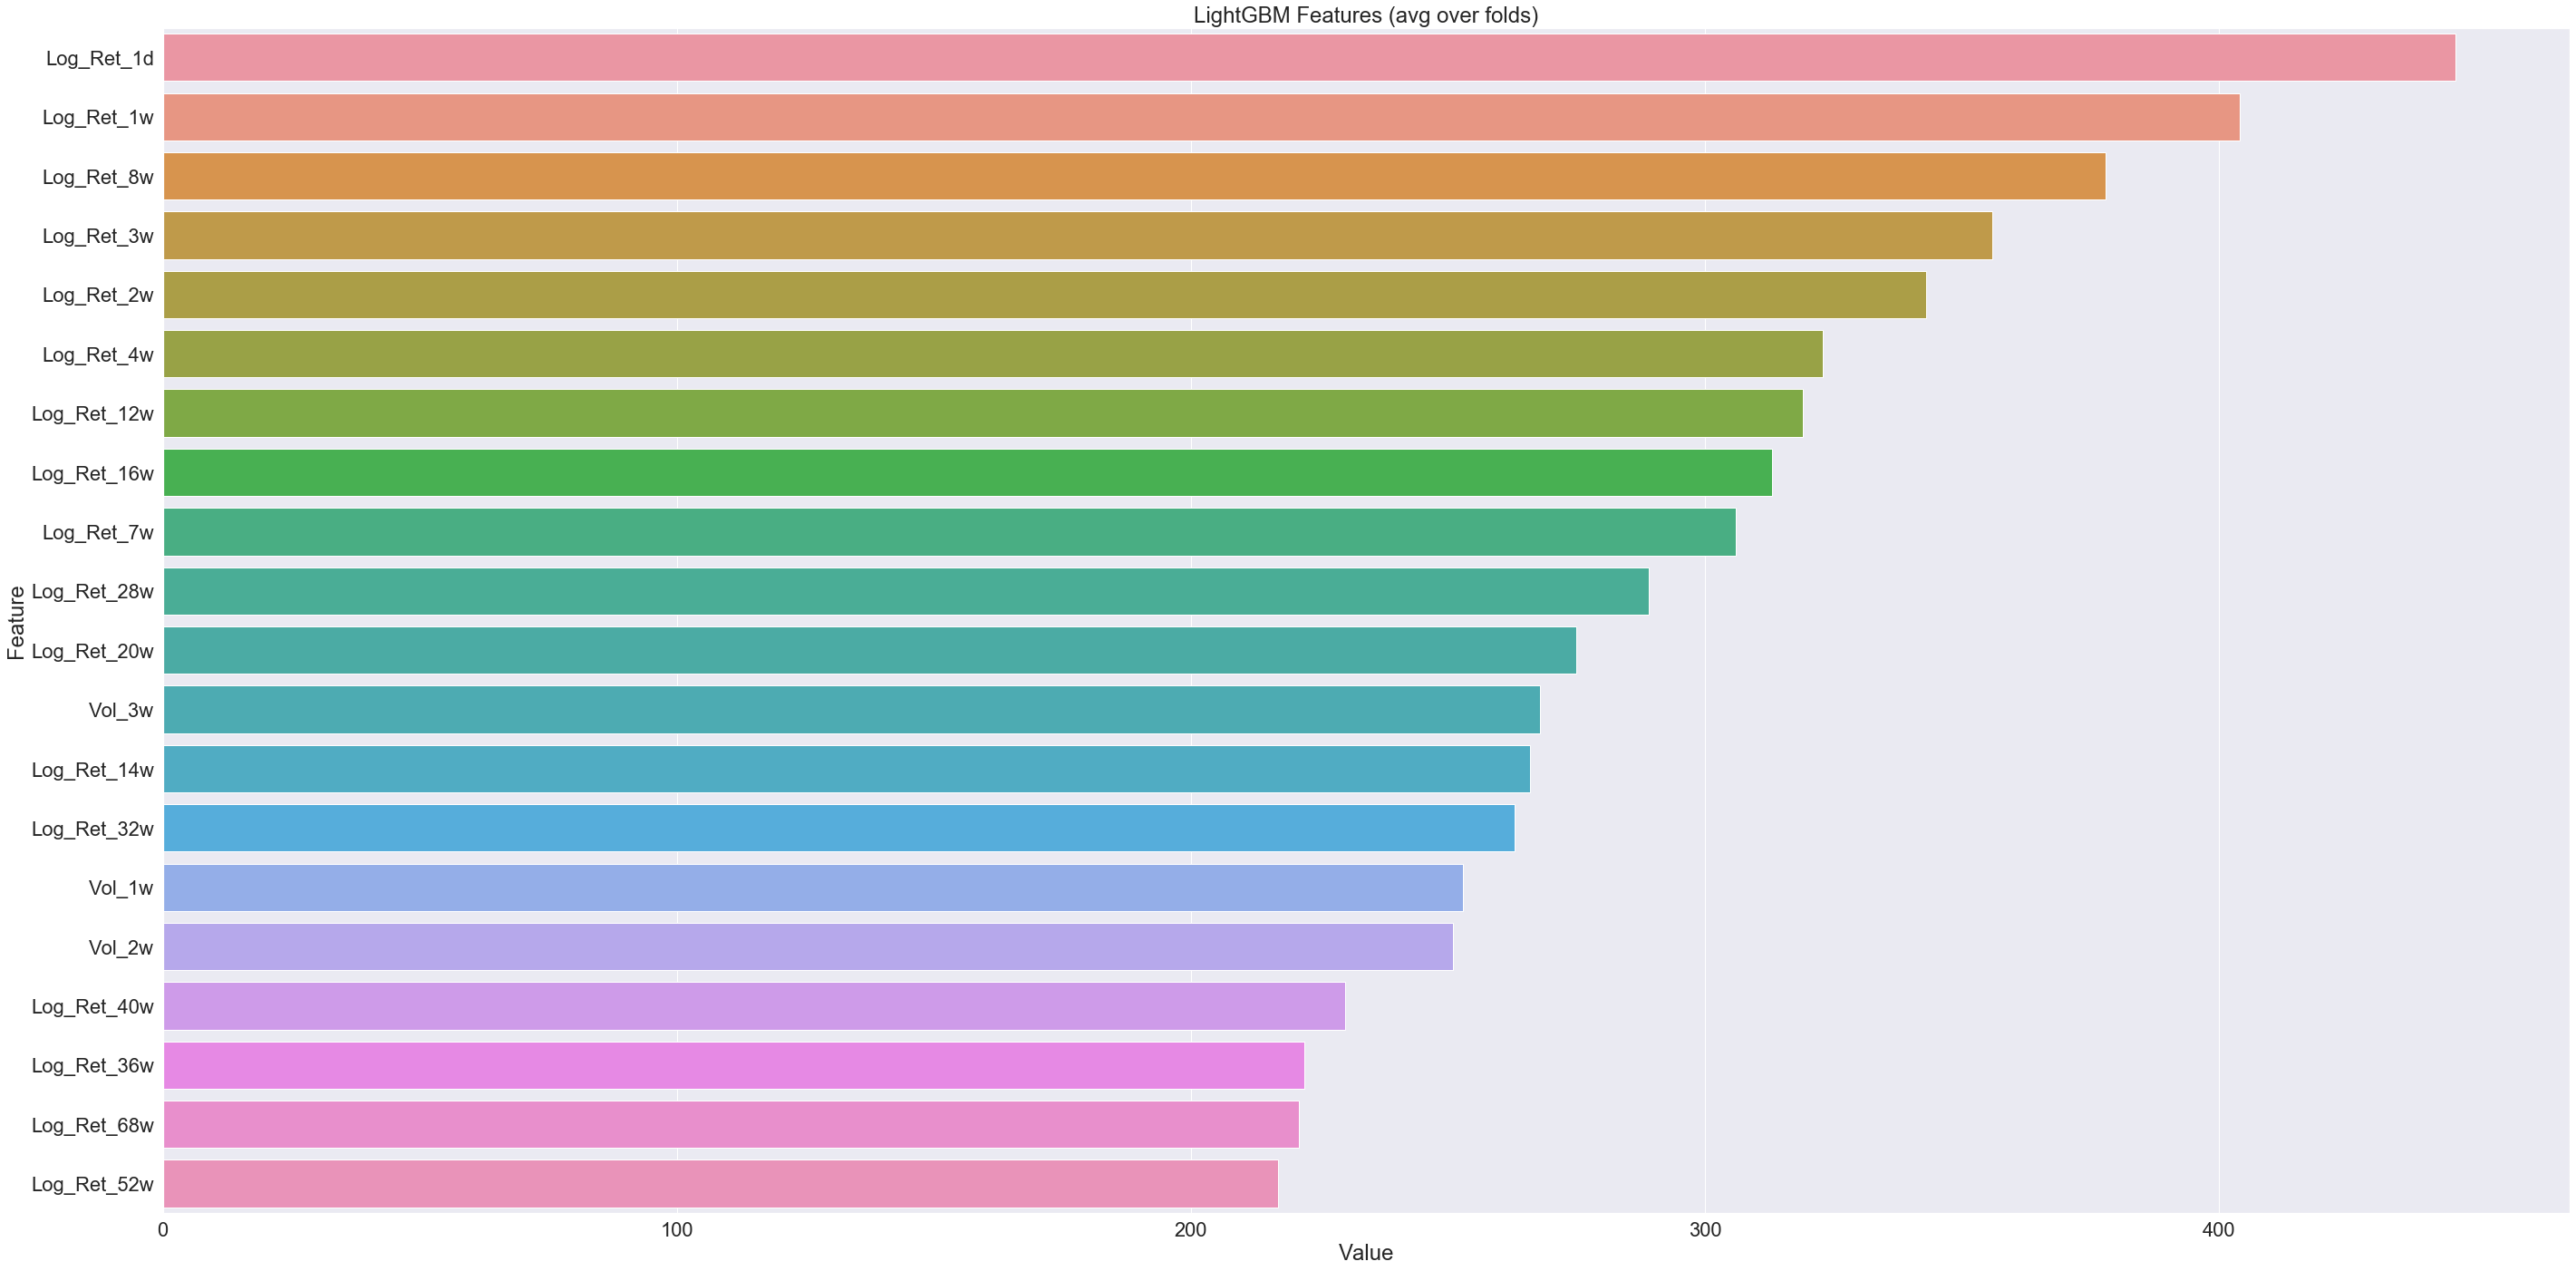

In [6]:
import lightgbm as lgb

# Making a Training and Testing set
data, target = sp500.iloc[:,0:(sp500.shape[1]-1)], sp500.iloc[:,(sp500.shape[1]-1)]
train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)

lgb_train = lgb.Dataset(train_x, train_y)
lgb_test = lgb.Dataset(valid_x, valid_y, reference=lgb_train)

params = {
    'lambda_l1' : 0.0009593260016534016,
    'lambda_l2' : 5.1016424945822117e-08,
    'num_leaves' : 147,
    'feature_fraction' : 0.49119763510092085,
    'bagging_fraction' : 0.5616838426181977,
    'bagging_freq' : 4,
    'min_child_samples' : 27 }

evals_result = {}  # to record eval results for plotting


print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_test],
                feature_name=['f' + str(i + 1) for i in range(train_x.shape[-1])],
                evals_result=evals_result,
                verbose_eval=10)


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
    
plotImp(gbm, train_x, 20)

#### If you would like you could change the number below to use less features. 

In [7]:
fs_indices_lgbm = np.argsort(gbm.feature_importance())[::-1][0:(sp500.shape[1]-1)] # change this to any number

## Making & Tunning the Model

In [8]:
import lightgbm as lgb
import numpy as np
import optuna
import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn.metrics


class Objective:

    def __init__(self):
        self.best_booster = None
        self._booster = None

    def __call__(self, trial):
        
        # Train test split
        data, target = sp500.iloc[:,0:(sp500.shape[1]-1)], sp500.iloc[:,(sp500.shape[1]-1)]
        train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
        
        # assign these values with the number of features we want
        train_x, train_y = train_x.iloc[:, fs_indices_lgbm], train_y 
        valid_x, valid_y = valid_x.iloc[:, fs_indices_lgbm], valid_y
        
        # turning these train/tests into lgb datasets
        dtrain = lgb.Dataset(train_x, label=train_y)
        dvalid = lgb.Dataset(valid_x, label=valid_y)

        param = {
            "objective": "binary",
            "metric": "auc",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
            "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        }

        # Add a callback for pruning.
        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
        gbm = lgb.train(
            param, dtrain, valid_sets=[dvalid], verbose_eval=False, callbacks=[pruning_callback]
        )

        self._booster = gbm

        preds = gbm.predict(valid_x)
        pred_labels = np.rint(preds)
        accuracy = sklearn.metrics.roc_auc_score(valid_y, pred_labels)
        return accuracy

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_booster = self._booster

In [9]:
objective = Objective()

# Setting SEED 
from optuna.samplers import TPESampler
sampler = TPESampler(seed=10)


study = optuna.create_study(
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize",
    sampler=sampler
)
study.optimize(objective, n_trials=50, callbacks=[objective.callback])

print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

best_model = objective.best_booster

[I 2020-06-13 18:29:30,409] Finished trial#0 with value: 0.5280744616231345 with parameters: {'lambda_l1': 0.08747537025773001, 'lambda_l2': 1.537331564587801e-08, 'num_leaves': 66, 'feature_fraction': 0.665808968613165, 'bagging_fraction': 0.8991468153827206, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial#0 with value: 0.5280744616231345.
[I 2020-06-13 18:29:30,932] Finished trial#1 with value: 0.5075969731275696 with parameters: {'lambda_l1': 6.061300044367956e-07, 'lambda_l2': 0.0699481785242808, 'num_leaves': 2, 'feature_fraction': 0.5581617076173714, 'bagging_fraction': 0.4902267203570596, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial#0 with value: 0.5280744616231345.
[I 2020-06-13 18:29:33,256] Finished trial#2 with value: 0.517435968445282 with parameters: {'lambda_l1': 0.22357153931242474, 'lambda_l2': 1.0583864232514661e-05, 'num_leaves': 90, 'feature_fraction': 0.8875725769912681, 'bagging_fraction': 0.7675156400976328, 'bagging_freq': 1, 'min_child_s

Best trial:
  Params: 
    lambda_l1: 6.51829697963914e-08
    lambda_l2: 5.085111847677709e-06
    num_leaves: 73
    feature_fraction: 0.44611330104774827
    bagging_fraction: 0.9118257941911949
    bagging_freq: 4
    min_child_samples: 33


## Importing Unseen Data

In [10]:
# Imports data
start_sp=datetime.datetime(1980, 1, 1) 
end_sp=datetime.datetime(2020, 6, 12) # less than 12 days of new data (business days only)

yf.pdr_override() 
sp500=pdr.get_data_yahoo('^GSPC', 
                        start_sp,
                        end_sp)

sp500.shape



[*********************100%***********************]  1 of 1 completed


(10200, 6)

In [11]:
sp500 = prepare_data(sp500)
target = sp500['Label'].values
sp500 = sp500.drop('Label', axis = 1)

In [12]:
new_preds = best_model.predict(sp500.iloc[:, fs_indices_lgbm])
new_pred_labels = np.rint(new_preds)
# Taking a look at the AUC 
print(sklearn.metrics.roc_auc_score(target, new_pred_labels))

0.8653973095099906


## Predictions on the last 10 business days that were unseen by the model

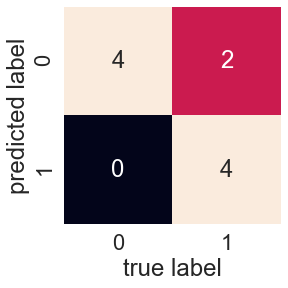

In [13]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target[-10:], new_pred_labels[-10:])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Predictions on the all business days including data it has seen before

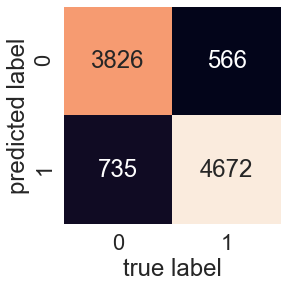

In [14]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(target, new_pred_labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');